In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re
from wordcloud import WordCloud
from collections import Counter
import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv("../data/train.tsv", sep="\t", encoding = "utf-8", header=None)
test_df = pd.read_csv("../data/test.tsv", sep="\t", encoding = "utf-8", header=None)
dev_df = pd.read_csv("../data/dev.tsv", sep="\t", encoding = "utf-8", header=None)

train_df.columns = ['text', 'emotions', 'id']
test_df.columns = ['text', 'emotions', 'id']
dev_df.columns = ['text', 'emotions', 'id']

In [3]:
train_df['emotions'] = list(map(lambda s : list(map(int, s.split(','))), train_df['emotions']))
test_df['emotions'] = list(map(lambda s : list(map(int, s.split(','))), test_df['emotions']))
dev_df['emotions'] = list(map(lambda s : list(map(int, s.split(','))), dev_df['emotions']))

In [4]:
train_df.head()

,text,emotions,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj


In [5]:
def emotions_to_ekman(df):
    # anger disgust fear joy sadness surprise neutral
    ekman = [3, 3, 0, 0, 3, 3, 5, 5, 3, 4, 0, 1, 4, 3, 2, 3, 4, 3, 3, 2, 3, 3, 5, 3, 4, 4, 5, 6]
    res = []

    for i in df['emotions']:
        tmp = [0, 0, 0, 0, 0, 0, 0]
        for j in i:
            tmp[ekman[j]] = 1
        res.append(tmp)
    tmp_df = pd.DataFrame(res, columns=['angry', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'])
    
    return tmp_df

In [6]:
train_df = pd.concat([train_df, emotions_to_ekman(train_df)], axis=1)
test_df = pd.concat([test_df, emotions_to_ekman(test_df)], axis=1)
dev_df = pd.concat([dev_df, emotions_to_ekman(dev_df)], axis=1)

In [7]:
train_df = train_df.drop(columns=['emotions', 'id'])
test_df = test_df.drop(columns=['emotions', 'id'])
dev_df = dev_df.drop(columns=['emotions', 'id'])

In [16]:
train_df.head()

,text,angry,disgust,fear,joy,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,1,0,0,0,0,0,0
3,To make her feel threatened,0,0,1,0,0,0,0
4,Dirty Southern Wankers,1,0,0,0,0,0,0


In [12]:
train_df.to_csv('../data/train_ekman.csv')
test_df.to_csv('../data/test_ekman.csv')
dev_df.to_csv('../data/dev_ekman.csv')

In [45]:
train_df = pd.read_csv('../data/train_ekman.csv')
test_df = pd.read_csv('../data/test_ekman.csv')
dev_df = pd.read_csv('../data/dev_ekman.csv')

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# 학습 전 모델 및 토크나이저 불러오기
model_name = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

num_labels = 7
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# 학습된 모델 및 토크나이저 불러오기
load_directory = "./model_saved"

model = AutoModelForSequenceClassification.from_pretrained(load_directory)
tokenizer = AutoTokenizer.from_pretrained(load_directory)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [8]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        text = str(self.data.loc[index, 'text'])
        labels = self.data.loc[index, ['angry', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']].values
        labels = labels.astype('float32')
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        
        return item


In [13]:
MAX_LEN = 512
BATCH_SIZE = 32

train_dataset = EmotionDataset(train_df, tokenizer, MAX_LEN)
test_dataset = EmotionDataset(test_df, tokenizer, MAX_LEN)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for batch in train_loader:
    print(batch)
    break

{'input_ids': tensor([[  101,   146,  1341,  ...,     0,     0,     0],
        [  101,   146,   787,  ...,     0,     0,     0],
        [  101, 25686,  1167,  ...,     0,     0,     0],
        ...,
        [  101,  2814,  1119,  ...,     0,     0,     0],
        [  101,   164,   151,  ...,     0,     0,     0],
        [  101,  1247,  1110,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1

In [36]:
from tqdm import tqdm

In [37]:
# optimizer 설정
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# 학습 시작
model.train()
epoch_num = 3
for epoch in range(epoch_num):
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epoch_num}')
    total_loss = 0
    
    for batch in progress_bar:
        # DataLoader가 반환하는 딕셔너리의 키를 올바르게 접근
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        # 라벨 컬럼을 'labels' 키로 묶어 전달
        # 데이터셋 클래스에서 이 부분 처리를 해야 함 (이전 답변 참조)
        labels = batch['labels'].to(device)

        # model의 출력
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        # 손실 계산 및 역전파
        # AutoModelForSequenceClassification은 'problem_type'이 'multi_label_classification'이면
        # 자동으로 Binary Cross-Entropy Loss를 계산하여 outputs.loss에 담습니다.
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Progress bar 업데이트
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epoch_num} completed! Average Loss: {avg_loss:.4f}")

Epoch 1/3: 100%|██████████| 1357/1357 [1:36:18<00:00,  4.26s/it, loss=0.1491]


Epoch 1/3 completed! Average Loss: 0.2567


Epoch 2/3: 100%|██████████| 1357/1357 [1:35:53<00:00,  4.24s/it, loss=0.2473]


Epoch 2/3 completed! Average Loss: 0.2031


Epoch 3/3: 100%|██████████| 1357/1357 [1:35:58<00:00,  4.24s/it, loss=0.1415]

Epoch 3/3 completed! Average Loss: 0.1748


In [9]:
# 저장할 디렉토리 경로 지정
save_directory = "./model_saved"

# 모델과 토크나이저 저장
model.save_pretrained(save_directory, from_pt=True)
tokenizer.save_pretrained(save_directory, from_pt=True)

NameError: name 'model' is not defined

In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_recall_curve

def evaluate_model(model, test_loader, device, emotion_names = ['angry', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']):
    """
    다중 라벨 분류 모델을 평가하는 통합 함수.
    정확도, F1-점수를 계산하고, 각 라벨에 대한 개별 Precision-Recall 곡선을 그립니다.
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            probs = torch.sigmoid(logits)
            predictions = (probs > 0.5).int()

            all_predictions.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    all_predictions = np.vstack(all_predictions)
    all_labels = np.vstack(all_labels)
    all_probs = np.vstack(all_probs)

    accuracy = accuracy_score(all_labels, all_predictions)
    
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='micro'
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='macro'
    )
    
    precision_per_label, recall_per_label, f1_per_label, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average=None
    )

    precision_macro_std = np.std(precision_per_label)
    recall_macro_std = np.std(recall_per_label)
    f1_macro_std = np.std(f1_per_label)

    print("--- 모델 평가 결과 ---")
    print(f"전체 샘플에 대한 정확도 (Exact Match Accuracy): {accuracy:.4f}")
    print("\n--- Micro 평균 지표 ---")
    print(f"Precision (Micro): {precision_micro:.4f}")
    print(f"Recall (Micro): {recall_micro:.4f}")
    print(f"F1-Score (Micro): {f1_micro:.4f}")
    print("\n--- Macro 평균 지표 ---")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    
    print("\n--- 라벨별 지표 ---")
    for i in range(len(emotion_names)):
        print(f"{emotion_names[i]} - Precision: {precision_per_label[i]:.4f}, Recall: {recall_per_label[i]:.4f}, F1-Score: {f1_per_label[i]:.4f}")
    
    print(f"\nPrecision (Macro) 표준편차: {precision_macro_std:.4f}")
    print(f"Recall (Macro) 표준편차: {recall_macro_std:.4f}")
    print(f"F1-Score (Macro) 표준편차: {f1_macro_std:.4f}")
    
    # 각 감정별 Precision-Recall 곡선 그리기
    n_classes = all_labels.shape[1]
    for i in range(n_classes):
        plt.figure(figsize=(6, 5))
        
        precision_curve, recall_curve, _ = precision_recall_curve(all_labels[:, i], all_probs[:, i])
        
        plt.plot(recall_curve, precision_curve, label=f'{emotion_names[i]}')
        plt.plot([0, 1], [1, 0], linestyle='--', color='gray')
        plt.xlabel('재현율 (Recall)')
        plt.ylabel('정밀도 (Precision)')
        plt.title(f'정밀도-재현율 곡선: {emotion_names[i]}')
        plt.grid(True)
        plt.legend()
        plt.show()

    return accuracy, f1_micro, f1_macro

--- 모델 평가 결과 ---
전체 샘플에 대한 정확도 (Exact Match Accuracy): 0.6025

--- Micro 평균 지표 ---
Precision (Micro): 0.7189
Recall (Micro): 0.6479
F1-Score (Micro): 0.6816

--- Macro 평균 지표 ---
Precision (Macro): 0.7126
Recall (Macro): 0.5379
F1-Score (Macro): 0.5975

--- 라벨별 지표 ---
angry - Precision: 0.5539, Recall: 0.5234, F1-Score: 0.5382
disgust - Precision: 0.7692, Recall: 0.2439, F1-Score: 0.3704
fear - Precision: 0.7867, Recall: 0.6020, F1-Score: 0.6821
joy - Precision: 0.8238, Recall: 0.8132, F1-Score: 0.8185
sadness - Precision: 0.7401, Recall: 0.4433, F1-Score: 0.5545
surprise - Precision: 0.6401, Recall: 0.5096, F1-Score: 0.5674
neutral - Precision: 0.6747, Recall: 0.6301, F1-Score: 0.6516

Precision (Macro) 표준편차: 0.0876
Recall (Macro) 표준편차: 0.1625
F1-Score (Macro) 표준편차: 0.1292


c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

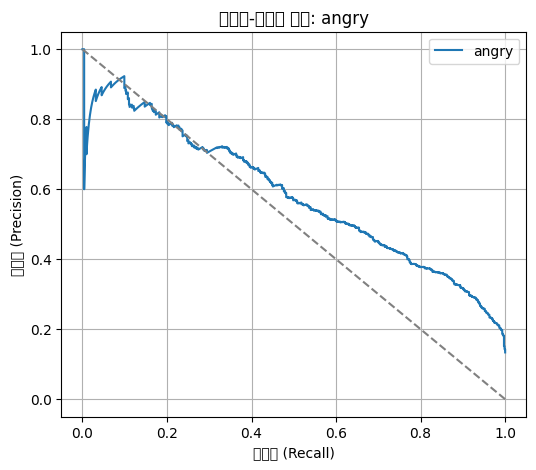

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

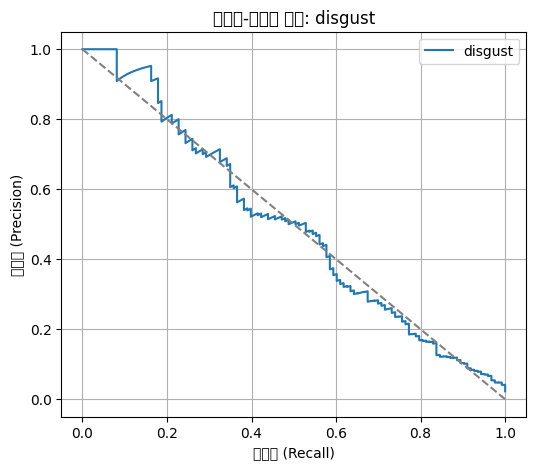

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

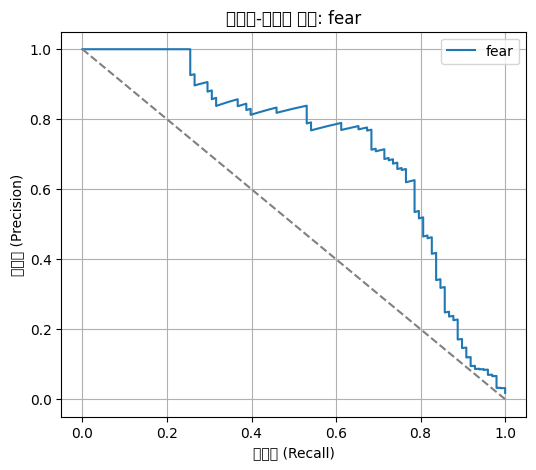

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

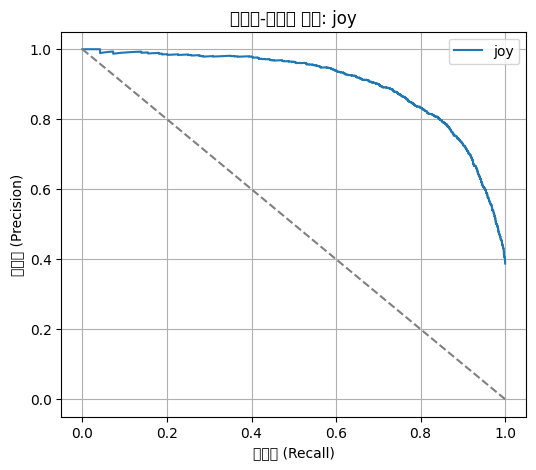

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

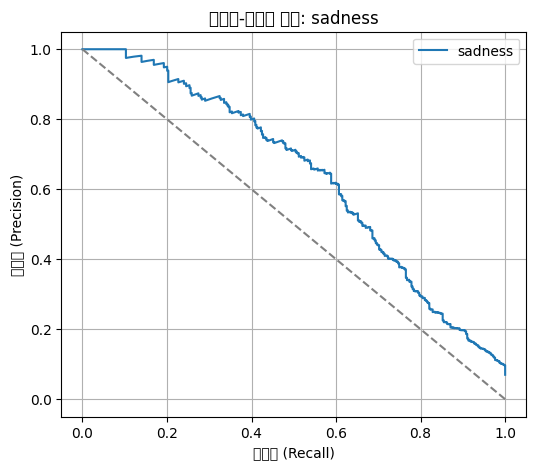

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

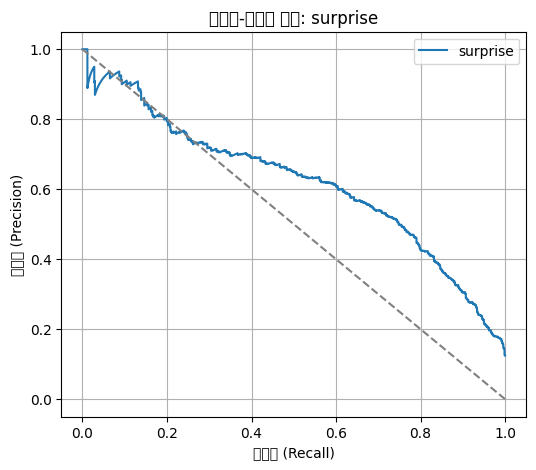

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

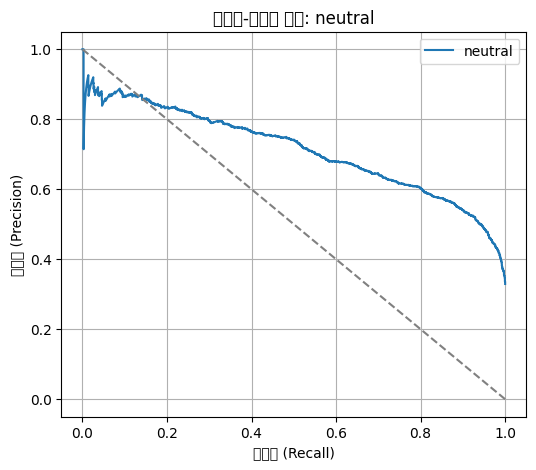

In [19]:
accuracy, f1_micro, f1_macro = evaluate_model(model, test_loader, device)